# Assembling All: Mark 1

In [227]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [228]:
images = {'hrf': cv2.imread('/Users/teguhsatya/Dev/T/dataset/samples/s_hrf.jpg'),
          'dgs':cv2.imread('/Users/teguhsatya/Dev/T/dataset/samples/s_drishti.png'),
          'rm': cv2.imread('/Users/teguhsatya/Dev/T/dataset/samples/s_rm.png')
         }

# Functions

In [ ]:
def all_to_rgb(imgs):
    rgb_imgs = {}
    for img in imgs:
        rgb_imgs[img] = cv2.cvtColor(imgs[img], cv2.COLOR_BGR2RGB)
    return rgb_imgs

def display_all_images(imgs, use_gray=False):
    fig, axs = plt.subplots(1, len(imgs), figsize=(18,10))
    for i, img in enumerate(imgs):
        if use_gray:
            axs[i].imshow(imgs[img], cmap='gray')
        else:
            axs[i].imshow(imgs[img])
        axs[i].set_title(img)

def display_all_with(imgs:dict, cc:int=0, use_gray:bool=True)->None:
    fig, axs = plt.subplots(1, len(imgs), figsize=(18,10))
    for i, img in enumerate(imgs):
        if use_gray:
            axs[i].imshow(imgs[img][:,:,cc], cmap='gray')
        else:
            axs[i].imshow(imgs[img])
        axs[i].set_title(img)
        
def resize_all(imgs, factor=50):
    resized_imgs = {}
    for img in imgs:
        resized_imgs[img] = cv2.resize(imgs[img], 
                                       (int(imgs[img].shape[1]*factor/100), 
                                        int(imgs[img].shape[0]*factor/100)), 
                                       cv2.INTER_AREA)
    return resized_imgs

def get_all_roi(imgs, wlim=135):
    rois = {}
    for img in imgs:
        if imgs[img].shape[0] > 252:
            gray_img = cv2.cvtColor(imgs[img].copy(), cv2.COLOR_RGB2GRAY)
            xmax = cv2.minMaxLoc(gray_img)[3][0]
            ymax = cv2.minMaxLoc(gray_img)[3][1]
            rois[img] = imgs[img][ymax-wlim:ymax+wlim,xmax-wlim:xmax+wlim]
        else:
            rois[img] = imgs[img]
    return rois

def adjust_gamma(image, gamma=1.0):
    table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

def remove_vessels(imgs):
    no_vsl = {}
    for img in imgs:
        g = imgs[img][:,:,1].copy()
        g_inv = 255-g
        g_gamma = adjust_gamma(g_inv.copy(), 5.0)
        g_gauss = cv2.GaussianBlur(g_gamma, (5,5),0)
        ret, th = cv2.threshold(g_gauss.copy(),0,255,
                                cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        no_vsl[img] = cv2.inpaint(imgs[img].copy(), th, 10,cv2.INPAINT_TELEA)
    return no_vsl

def get_which_ellipse(contours):
    conts = np.array([contour.shape[0] for contour in contours])
    cont_idx = np.argmax(conts)
    ellipse = cv2.fitEllipse(contours[cont_idx])
    return ellipse

# tidak harus ada draw line
def draw_roi_line(imgs, roi_line, color):
    odlines = {}
    for img in imgs:
        odlines[img] = cv2.ellipse(imgs[img], 
                                   roi_line[img], 
                                   color, 
                                   1, 
                                   cv2.LINE_AA)
    return odlines

def extract_od(imgs):
    # tidak harus ada drawn_roi
    drawn_roi = {}
    ods = {}
    for img in imgs:
        red = imgs[img][:,:,0]
        gmcr = adjust_gamma(red, 5.0)
        clahe = cv2.createCLAHE(5, (8,8))
        gmclahe = clahe.apply(gmcr)
        gmcr_bl = cv2.GaussianBlur(gmclahe, (15,15), 0)
        erosion = cv2.erode(gmcr_bl.copy(), kernel=np.ones((10,10), np.uint8))
        dilation = cv2.dilate(erosion, kernel=np.ones((10,10), np.uint8))
        ret2, th2 = cv2.threshold(dilation,0,255,
                                  cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        cont, hcy = cv2.findContours(th2.copy(), 
                                     cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        ellipse = get_which_ellipse(cont)
            
        od = np.zeros_like(th2, dtype='uint8')
        cv2.ellipse(od, ellipse, (255, 255, 255), -1)
        ods[img] = od
        drawn_roi[img] = ellipse

    return drawn_roi, ods

def extract_oc(imgs):
    ocs = {}
    drawn_oc = {}
    for img in imgs:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
        dilate = cv2.dilate(imgs[img], kernel)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        erode = cv2.erode(dilate.copy(), kernel)
        blur = cv2.GaussianBlur(erode[:,:,1], (23,23), 0)
        gammablur = adjust_gamma(blur, 7)
        ret3, th3 = cv2.threshold(gammablur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        cont, hcy = cv2.findContours(th3.copy(), 
                                     cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        ellipse = get_which_ellipse(cont)
            
        oc = np.zeros_like(th3, dtype='uint8')
        cv2.ellipse(oc, ellipse, (255, 255, 255), -1)
        ocs[img] = oc
        drawn_oc[img] = ellipse

    return drawn_oc, ocs

In [230]:
rgb_imgs = all_to_rgb(images)

In [231]:
rsz_imgs = resize_all(rgb_imgs)

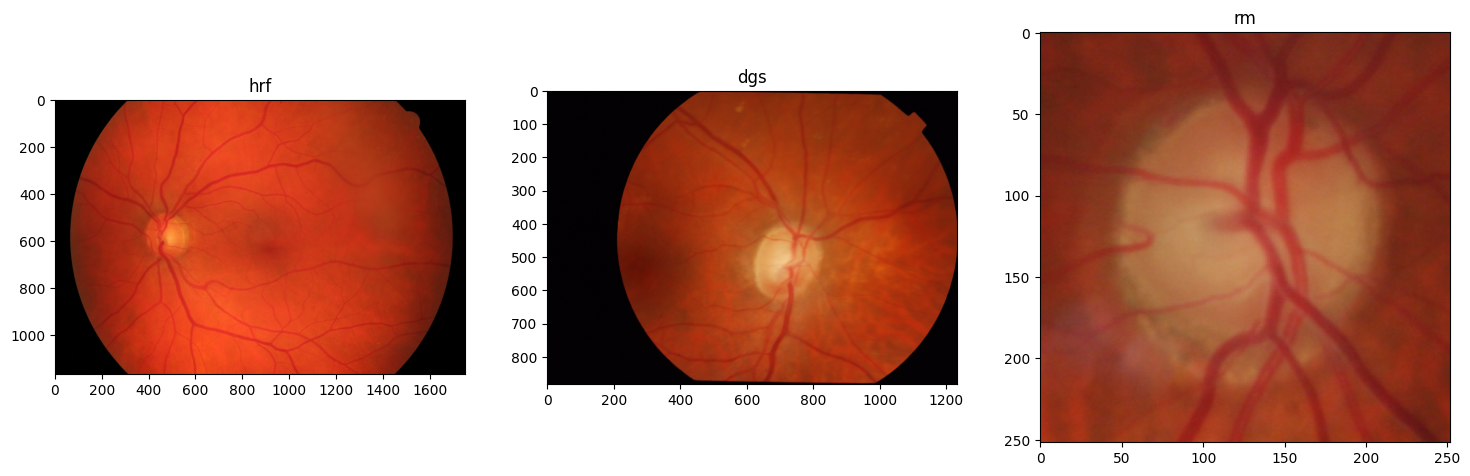

In [232]:
display_all_images(rsz_imgs)

In [233]:
rsz_imgs['rm'].shape

(252, 252, 3)

In [234]:
all_roi = get_all_roi(rsz_imgs.copy())

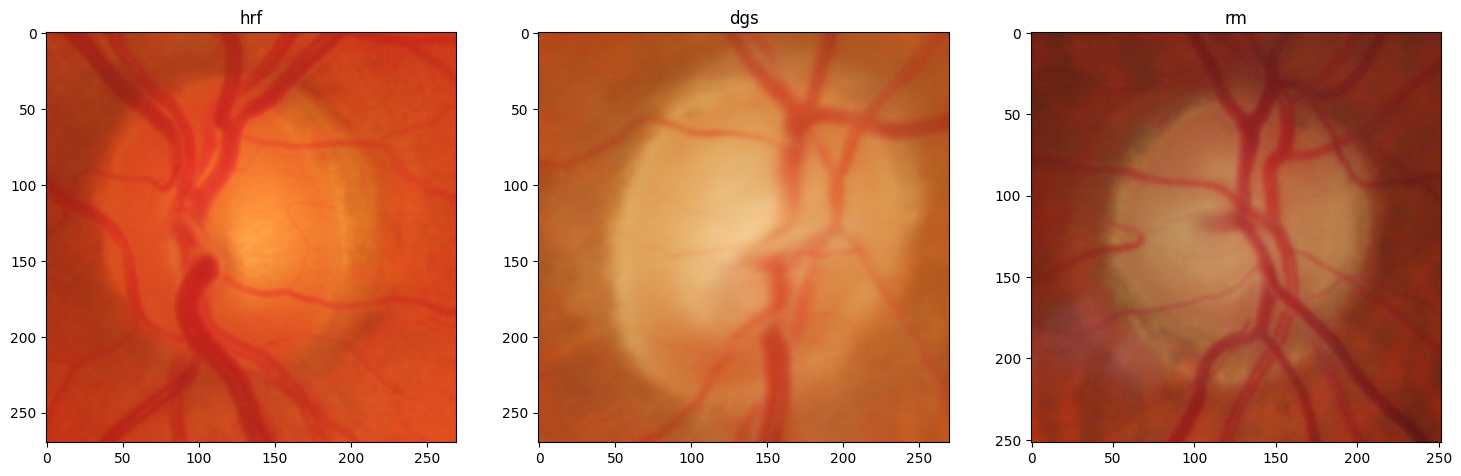

In [235]:
display_all_images(all_roi)

# Hilangkan Pembuluh Darah

In [236]:
wo_vsl = remove_vessels(all_roi.copy())

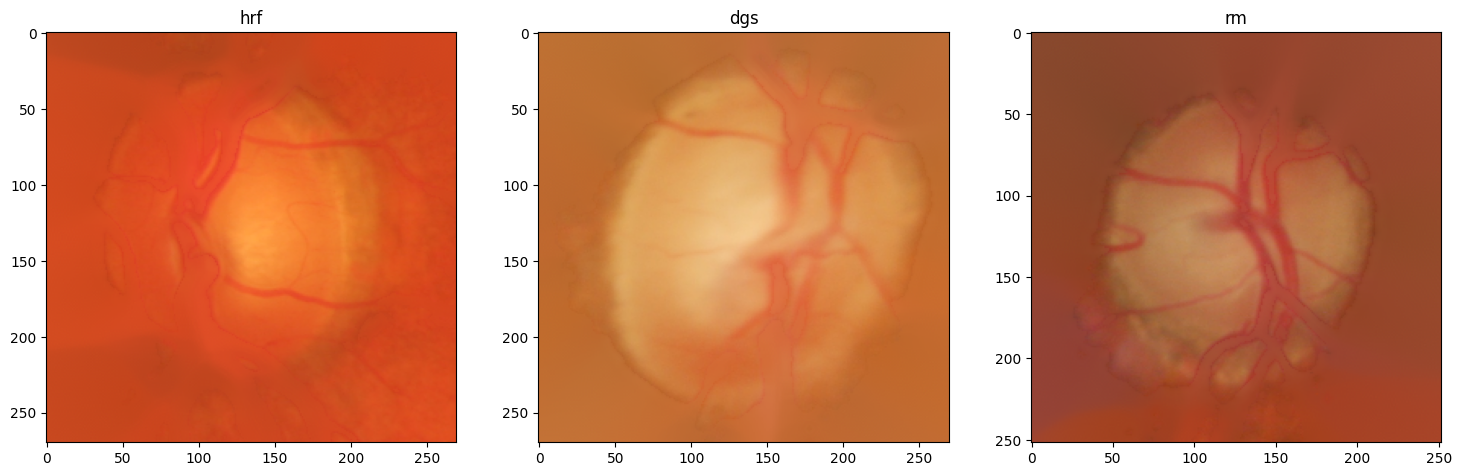

In [237]:
display_all_images(wo_vsl)

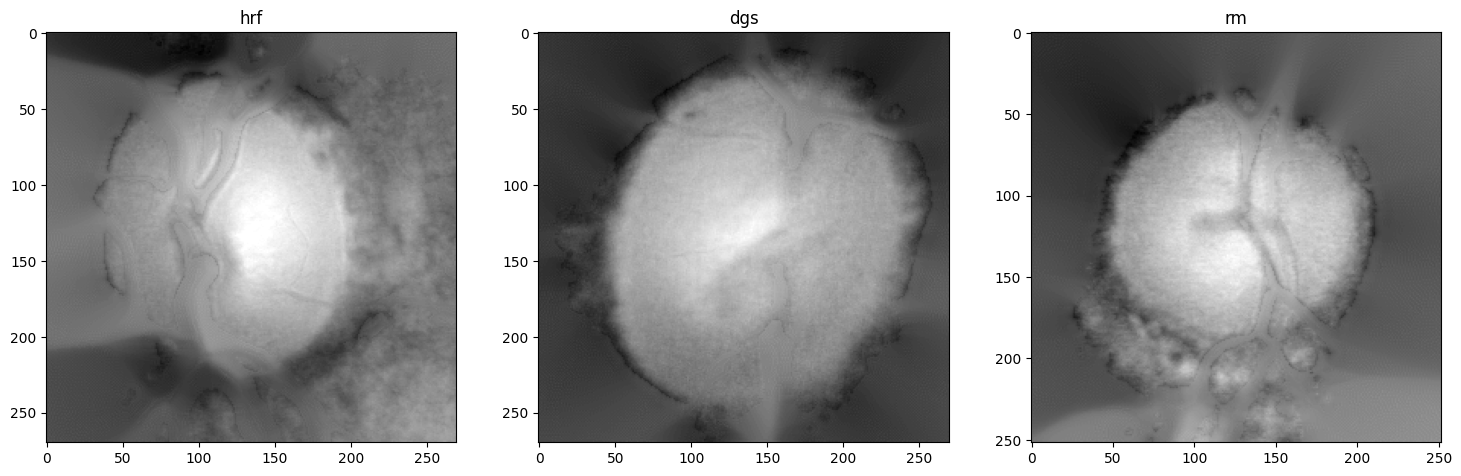

In [238]:
display_all_with(wo_vsl, 0)

# Optic Disc Extraction

In [239]:
od_line, all_od = extract_od(wo_vsl.copy())

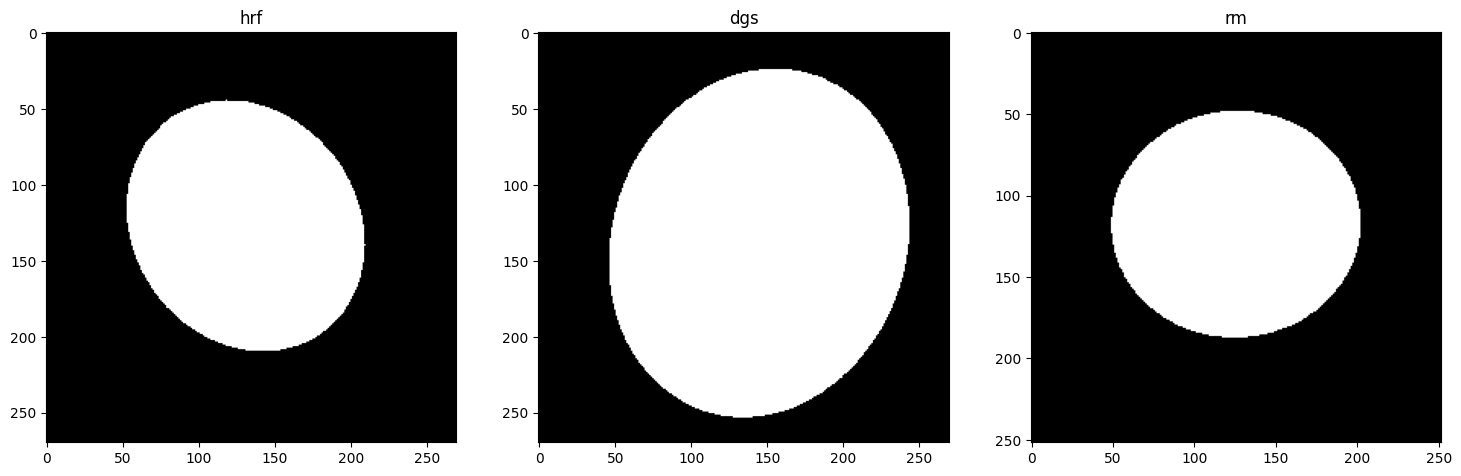

In [240]:
display_all_images(all_od, True)

# Optic Cup Extraction

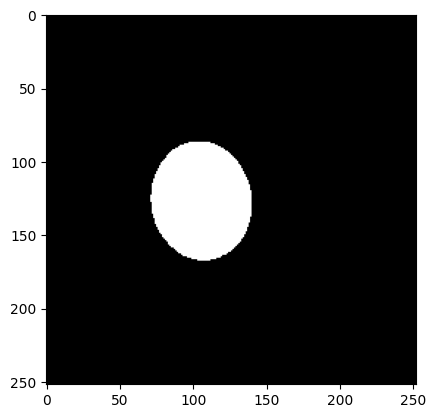

In [244]:
oc_line, ocs = extract_oc(all_roi.copy())

In [245]:
roic = all_roi.copy()

In [246]:
draw_od = draw_roi_line(roic, od_line, (0,255,0))
draw_oc = draw_roi_line(draw_od, oc_line, (0,0,255))

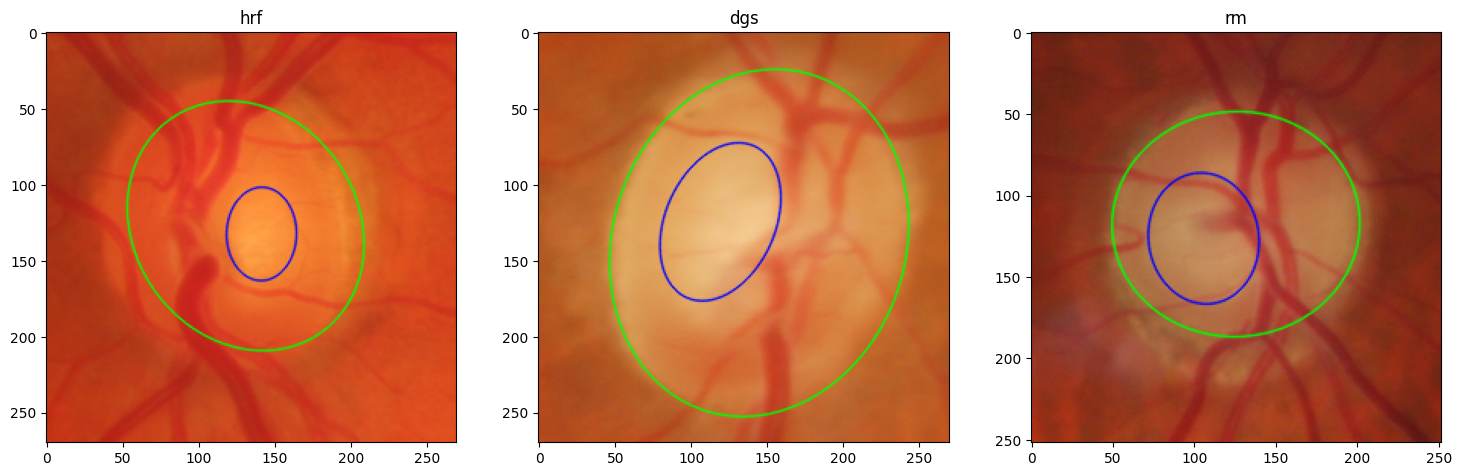

In [247]:
display_all_images(draw_oc)